# Predicting sport specific performance from field testing in synchronized swimming
Romain Martinez ([GitHub](https://github.com/romainmartinez))

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="paper")

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
import altair as alt

In [3]:
NORMALIZE = 'False'

## Get the data

In [4]:
DATA_PATH = Path("./data/zTable.xlsx")
df = pd.read_excel(DATA_PATH)

df.head()

,Name,Height,Weight,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,...,FLEX/D,EB max force,EB mean force,EB sd force,EB max height,EB min height,EB mean height,EB sd height,EB max-min height,BB
0,'aissatou_sougou',1.69,48.52,287.05,285.00,206.85,179.90,92.85,94.95,52.3,...,146.00,8.33,6.770000,0.439447,8.5,7.5,8.083333,0.376386,1.0,9.5
1,'anais_charland',1.63,62.13,292.75,302.75,239.85,207.85,109.25,103.25,98.4,...,123.35,9.43,7.762753,0.584721,7.5,7.0,7.083333,0.204124,0.5,8.5
2,'anne sophie_moreau',1.71,54.90,252.40,258.55,233.45,233.65,69.30,68.80,120.0,...,204.80,8.76,6.725683,0.767079,8.0,7.5,7.833333,0.258199,0.5,8.5
3,'audrey_lamothe',1.50,43.44,213.45,227.40,174.00,132.10,54.20,56.40,39.9,...,112.25,9.86,7.315823,0.815853,8.0,7.0,7.416667,0.376386,1.0,8.5
4,'billie_francis',1.78,62.04,281.75,296.20,258.65,227.25,97.25,99.05,77.2,...,152.85,10.77,8.995158,0.570680,7.5,7.0,7.333333,0.258199,0.5,9.0


In [5]:
# variables
variables = [
    "ADD/G",
    "ADD/D",
    "ABD/G",
    "ABD/D",
    "ER/G",
    "ER/D",
    "IR/G",
    "IR/D",
    "EXT/G",
    "EXT/D",
    "FLEX/G",
    "FLEX/D",
]
X = df[variables] / 9.81
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,29.260958,29.051988,21.085627,18.338430,9.464832,9.678899,5.331295,5.295617,16.987768,20.050968,18.654434,14.882773
1,29.841998,30.861366,24.449541,21.187564,11.136595,10.524975,10.030581,8.567788,31.396534,26.243629,15.963303,12.573904
2,25.728848,26.355759,23.797146,23.817533,7.064220,7.013252,12.232416,12.212029,14.383282,11.539246,20.341488,20.876656
3,21.758410,23.180428,17.737003,13.465851,5.524975,5.749235,4.067278,3.792049,14.123344,0.203874,12.003058,11.442406
4,28.720693,30.193680,26.365953,23.165138,9.913354,10.096840,7.869521,6.365953,21.116208,17.018349,16.156983,15.581040


In [6]:
targets = ["BB", "EB mean height", "EB mean force"]
y = df[targets].rename(
    columns={"BB": "BB-H", "EB mean height": "EB-H", "EB mean force": "EB-F"}
)
y.head()

,BB-H,EB-H,EB-F
0,9.5,8.083333,6.770000
1,8.5,7.083333,7.762753
2,8.5,7.833333,6.725683
3,8.5,7.416667,7.315823
4,9.0,7.333333,8.995158


## Normalize data
We should normalize the field tests (`X`) by anthropometric measurements.

In [7]:
if NORMALIZE == "weight":
    normalizer = df["Weight"]
elif NORMALIZE == "IMC":
    normalizer = df["Weight"] / df["Height"] ** 2
elif NORMALIZE == "weight-height":
    normalizer = df["Weight"] * df["Height"]
else:
    normalizer = 1
    print("data not normalized")
X = X.divide(normalizer, axis=0)

data not normalized


## NaN remover

In [8]:
nan_id = np.argwhere(np.isnan(X.values))
for i in nan_id:
    print(f'participant no.: {i[0]}')
    print(f'\ttest: {X.columns[i[1]]}')
    # if left take right, left otherwise
    if X.columns[i[1]][-1] == 'G':
        replacer = i[1] + 1
    else:
        replacer = i[1] - 1
    print(f'\t\t"{X.iloc[i[0], i[1]]}" replace by "{X.iloc[i[0], replacer]}"')
    X.at[i[0], X.columns[i[1]]] = X.at[i[0], X.columns[replacer]]

participant no.: 5
	test: ADD/D
		"nan" replace by "32.95107033639144"
participant no.: 41
	test: IR/G
		"nan" replace by "12.125382262996942"
participant no.: 90
	test: IR/G
		"nan" replace by "9.403669724770642"


## Data description

### Variables $X$
Hip strength tests (field testing):
- `ADD`: adduction test
- `ABD`: abduction test
- `ER`: external rotation test
- `IR`: internal rotation test
- `EXT`: extension test
- `FLEX`: flexion test

### Targets $y$

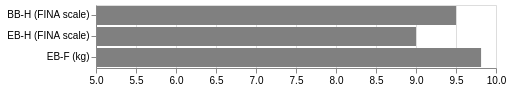

In [9]:
test_cols_renamed = {
    "BB-H": "BB-H (FINA scale)",
    "EB-H": "EB-H (FINA scale)",
    "EB-F": "EB-F (kg)",
}

test_cols_order = ["BB-H (FINA scale)", "EB-H (FINA scale)", "EB-F (kg)"]

(
    alt.Chart(y.rename(columns=test_cols_renamed).melt())
    .mark_bar(color="grey")
    .encode(
        alt.X(
            "value",
            title="",
            scale=alt.Scale(zero=False),
            axis=alt.Axis(labelFlush=False),
        ),
        alt.Y("variable", title=None, scale=alt.Scale(domain=test_cols_order)),
    )
)

## Add features

### Fscore
Let's try to transform each *left* and *right* tests into a single "Fscore" such as:
$$F_{\text{score}} = 2 \times \frac{\text{left} \times \text{right}}{\text{left} + \text{right}}$$

This formula favors left & right tests that are similar and therefore penalizes asymmetries.

In [10]:
def f_score(a, b):
    """Takes two columns and compute the F score."""
    return 2 * (a * b) / (a + b)

### Imbalance

In [11]:
def imbalance(a, b):
    """compute the imbalance score, in percentage."""
    return np.abs((a - b) / a) * 100

In [12]:
X_augmented = pd.DataFrame()
for name, icol in X.iteritems():
    b = np.empty(0)
    if name[-1] == 'G':
        a = icol
    else:
        b = icol
    if b.any():
        X_augmented[name[:-2]] = f_score(a, b)
        X_augmented[f'imb. {name[:-2]}'] = imbalance(a, b)

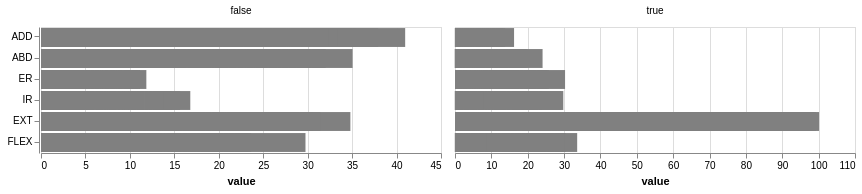

In [13]:
test_cols = ["ADD", "ABD", "ER", "IR", "EXT", "FLEX"]

alt.Chart().mark_bar(color="grey").encode(
    alt.X("value"), alt.Y("variable", title=None, scale=alt.Scale(domain=test_cols))
).facet(
    data=X_augmented.melt().assign(
        imb=lambda x: x["variable"].str[:3] == "imb",
        variable=lambda x: x["variable"].str.replace("imb. ", ""),
    ),
    column=alt.Column("imb", title=None),
).resolve_scale(
    x="independent"
)

### Anthropometry

In [14]:
X_augmented['Height'] = df['Height']
X_augmented['Mass'] = df['Weight']

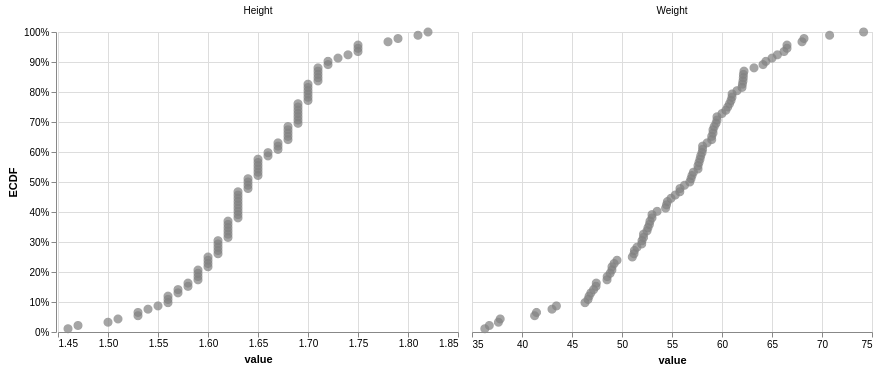

In [15]:
alt.Chart().mark_circle(color="grey", size=80).encode(
    alt.X("value", scale=alt.Scale(zero=False)),
    alt.Y("ECDF", axis=alt.Axis(format="%")),
).facet(
    data=df[["Height", "Weight"]]
    .melt()
    .assign(
        ECDF=lambda d: d.groupby("variable").transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    ),
    column=alt.Column("variable", title=None),
).resolve_scale(
    x="independent"
)

## Fitting an ensemble model

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y, test_size=0.2, random_state=RANDOM_SEED
)

### Helper functions

In [17]:
from sklearn.metrics import mean_squared_error


def mape(y_test, y_pred):
    return (np.abs((y_test - y_pred) / y_test)) * 100


def mae(y_test, y_pred):
    return np.abs(y_test - y_pred)


def evaluate(y_test, y_pred):
    d = {"mae": mae(y_test, y_pred), "mape": mape(y_test, y_pred)}
    print(
        f"""
    \tmae = {d['mae'].mean():.3f} ({d['mae'].std():.3f})
    \tmape = {d['mape'].mean():.3f}% ({d['mape'].std():.3f})
    """
    )
    return d

In [18]:
# from skopt import BayesSearchCV, dump, load


# class BayesSearch:
#     def __init__(self, model, search_spaces, n_iter, export_path):
#         self.export_path = export_path
#         self.bayes_cv_tuner = BayesSearchCV(
#             model,
#             search_spaces,
#             cv=5,
#             n_jobs=-1,
#             n_iter=n_iter,
#             verbose=0,
#             refit=True,
#             random_state=RANDOM_SEED,
#         )

#     def fit(self, X, y):
#         self.bayes_cv_tuner.fit(X, y, callback=self.print_status)
#         self.export_results()

#     def export_results(self):
#         pd.DataFrame(self.bayes_cv_tuner.cv_results_).to_csv(
#             f"{self.export_path}_cv_results.csv"
#         )
#         pd.Series(self.bayes_cv_tuner.best_params_).to_json(
#             f"{self.export_path}_best_params.json"
#         )
#         dump(self.bayes_cv_tuner, f"{self.export_path}_bayes_search.pkl")

#     def print_status(self, optim_results):
#         print(
#             f"""
# Model #{len(opt.bayes_cv_tuner.cv_results_['params'])}
# Best: {self.bayes_cv_tuner.best_score_}
# Best params: {self.bayes_cv_tuner.best_params_}
#         """
#         )

### Fit model

In [19]:
from xgboost import XGBRegressor

OPT = False
ITERATIONS = 100

params = {"n_jobs": 1, "silent": 1, "tree_method": "approx"}

if OPT:
    for itarget in y.columns:
        OPT_EXPORT = f"opt/{itarget}"

        search_spaces = {
            "learning_rate": (0.01, 1.0, "log-uniform"),
            "min_child_weight": (0, 10),
            "max_depth": (0, 50),
            "max_delta_step": (0, 20),
            "subsample": (0.01, 1.0, "uniform"),
            "colsample_bytree": (0.01, 1.0, "uniform"),
            "colsample_bylevel": (0.01, 1.0, "un|iform"),
            "reg_lambda": (1e-9, 1000, "log-uniform"),
            "reg_alpha": (1e-9, 1.0, "log-uniform"),
            "gamma": (1e-9, 0.5, "log-uniform"),
            "min_child_weight": (0, 5),
            "n_estimators": (50, 100),
            "scale_pos_weight": (1e-6, 500, "log-uniform"),
        }

        opt = BayesSearch(
            model=XGBRegressor(**params),
            search_spaces=search_spaces,
            n_iter=ITERATIONS,
            export_path=OPT_EXPORT,
        )
        opt.fit(X_train, y_train[itarget])

In [20]:
USE_OPT = False

boosted = {}
evaluation = {}

RANDOM_SEED = 15
np.random.seed(RANDOM_SEED)

for itarget, itarget_name in enumerate(y_train.columns):
    print(f"\t{itarget}. {itarget_name}\n")

    opt_params = (
        load(f"opt/{itarget_name}_bayes_search.pkl").best_params_ if USE_OPT else {}
    )

    boosted[itarget_name] = XGBRegressor(
        **{**params, **opt_params}, random_state=RANDOM_SEED
    )
    boosted[itarget_name].fit(
        X_train,
        y_train[itarget_name],
        eval_set=[(X_train, y_train[itarget_name]), (X_test, y_test[itarget_name])],
        early_stopping_rounds=50,
        eval_metric="rmse",
        verbose=50,
    )

    evaluation[itarget_name] = evaluate(
        y_test[itarget_name], boosted[itarget_name].predict(X_test)
    )
    evaluation[itarget_name]["test"] = [
        itarget_name for i in range(len(evaluation[itarget_name]["mae"]))
    ]

    print(f'{"-" * 30}\n')
evaluation = pd.concat([pd.DataFrame(evaluation[itest]) for itest in evaluation.keys()])

	0. BB-H

[0]	validation_0-rmse:7.41009	validation_1-rmse:7.61465
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.20484	validation_1-rmse:0.624062
[99]	validation_0-rmse:0.07597	validation_1-rmse:0.580138

    	mae = 0.518 (0.267)
    	mape = 5.853% (3.063)
    
------------------------------

	1. EB-H

[0]	validation_0-rmse:6.40972	validation_1-rmse:6.18042
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.187028	validation_1-rmse:0.55857
Stopping. Best iteration:
[44]	validation_0-rmse:0.229892	validation_1-rmse:0.555945


    	mae = 0.437 (0.353)
    	mape = 6.187% (5.566)
    
------------------------------

	2. EB-F

[0]	validation_0-rmse:6.04267	validation_1-rmse:6.33821
Multiple eval metrics have been passed: 'val

/home/romain/miniconda3/envs/synchro/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/romain/miniconda3/envs/synchro/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


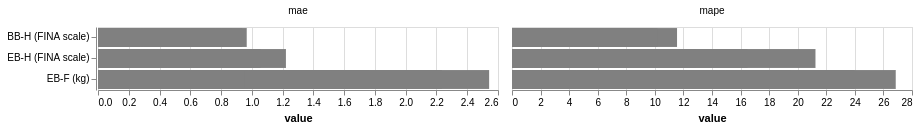

In [21]:
alt.Chart().mark_bar(color="grey").encode(
    alt.X("value"), alt.Y("test", title=None, scale=alt.Scale(domain=test_cols_order))
).facet(
    data=evaluation.replace(test_cols_renamed).melt(id_vars="test"),
    column=alt.Column("variable", title=None),
).resolve_scale(
    x="independent"
)

In [22]:
evaluation.groupby('test').mean()['mape'].sum()

24.56533763404073

In [23]:
ecdf = (
    evaluation.replace(test_cols_renamed)
    .melt(id_vars="test")
    .assign(
        ECDF=lambda d: d.groupby(["test", "variable"]).transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
)
ecdf.head()

,test,variable,value,ECDF
0,BB-H (FINA scale),mae,0.121917,0.052632
1,BB-H (FINA scale),mae,0.243045,0.157895
2,BB-H (FINA scale),mae,0.359110,0.421053
3,BB-H (FINA scale),mae,0.296380,0.315789
4,BB-H (FINA scale),mae,0.719373,0.736842


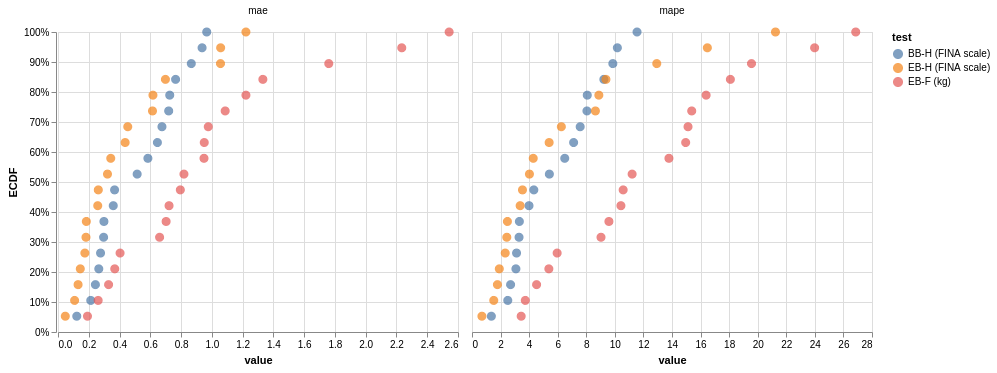

In [24]:
alt.Chart().mark_circle(size=80).encode(
    alt.X("value"),
    alt.Y("ECDF", axis=alt.Axis(format="%")),
    alt.Color("test", sort=test_cols_order),
).facet(data=ecdf, column=alt.Column("variable", title=None)).resolve_scale(
    x="independent"
)

### Bayesian Estimation Supersedes the T-Test

This model replicates the example used in: Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.

In [25]:
# from itertools import combinations
# from pathlib import Path

# import numpy as np
# import pandas as pd
# import pymc3 as pm


# def best(data, value, group):
#     """
#     This model replicates the example used in:
#     Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.
#     The original model is extended to handle multiple groups.

#     Parameters
#     ----------
#     data: pandas.DataFrame
#         Tidy pandas dataframe
#     value: str
#         Name of the column holding the values
#     group: str
#         Name of the column holding the groups
#     Returns
#     -------
#     pymc3.Model
#     """
#     groups = data[group].unique()

#     # pooled empirical mean of the data and twice the pooled empirical standard deviation
#     mu = data[value].mean()
#     sd = data[value].std() * 2

#     # group standard deviations priors
#     σ = [0.05, 0.5]

#     with pm.Model() as model:
#         groups_means = {
#             igroup: pm.Normal(f"{igroup}_mean", mu=mu, sd=sd) for igroup in groups
#         }
#         groups_std = {
#             igroup: pm.Uniform(f"{igroup}_std", lower=σ[0], upper=σ[-1])
#             for igroup in groups
#         }

#         # prior for ν exponentially distributed with a mean of 30
#         ν = pm.Exponential("ν_minus_one", lam=1 / 29.0) + 1

#         # precision (transformed from standard deviations)
#         λ = {igroup: groups_std[igroup] ** -2 for igroup in groups}

#         likelihoods = {
#             igroup: pm.StudentT(
#                 igroup,
#                 nu=ν,
#                 mu=groups_means[igroup],
#                 lam=λ[igroup],
#                 observed=data.query(f'{group} == "{igroup}"')[value].dropna(),
#             )
#             for igroup in groups
#         }

#         delta_means, delta_std, effect_size = {}, {}, {}
#         for a, b in combinations(groups, 2):
#             a_minus_b = f"{a} - {b}"
#             delta_means[a_minus_b] = pm.Deterministic(
#                 f"Δμ ({a_minus_b})", groups_means[a] - groups_means[b]
#             )
#             delta_std[a_minus_b] = pm.Deterministic(
#                 f"Δσ ({a_minus_b})", groups_std[a] - groups_std[b]
#             )
#             effect_size[a_minus_b] = pm.Deterministic(
#                 f"effect size ({a_minus_b})",
#                 delta_means[a_minus_b]
#                 / np.sqrt((groups_std[a] ** 2 + groups_std[b] ** 2) / 2),
#             )
#     return model

In [26]:
# SAMPLE = False
# MODEL_PATH = Path("./model/stats")

# trace = {}
# for imuscle in MUSCLES:
#     m = best(data=df_comp.query("muscle == @imuscle"), value="mape", group="method")
#     with m:
#         if SAMPLE:
#             trace[imuscle] = pm.sample(10_000, tune=10_000, random_seed=RANDOM_SEED)
#             pm.save_trace(
#                 trace[imuscle], directory=MODEL_PATH / imuscle, overwrite=True
#             )
#         else:
#             trace[imuscle] = pm.load_trace(MODEL_PATH / imuscle, model=m)

## Interpretation

In [27]:
import shap

shap.initjs()

explainer = {itarget: shap.TreeExplainer(boosted[itarget]) for itarget in y.columns}
shap_values = {
    itarget: explainer[itarget].shap_values(X_augmented) for itarget in y.columns
}

### How important are our features?
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.

The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

In [28]:
shap_df = pd.concat(
    [
        pd.DataFrame(shap_values[i], columns=X_train.columns).assign(target=i)
        for i in y.columns
    ]
)

In [29]:
shap_df_abs = shap_df.copy()
shap_df_abs[X_train.columns] = shap_df_abs[X_train.columns].abs()

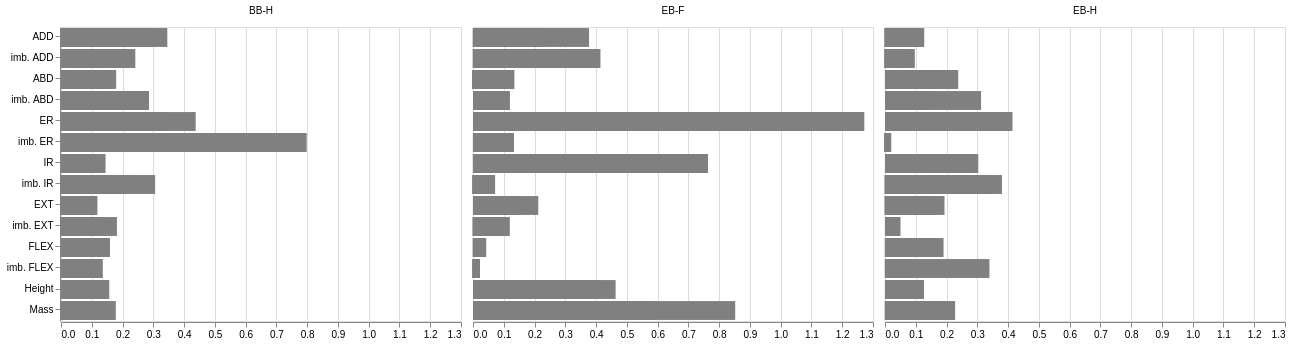

In [30]:
alt.Chart(shap_df_abs.melt(id_vars="target")).mark_bar(color="grey").encode(
    alt.X("value", title=None),
    alt.Y(
        "variable",
        title=None,
        scale=alt.Scale(domain=shap_df_abs.drop("target", axis=1).columns.tolist()),
    ),
    alt.Column("target", title=None),
)

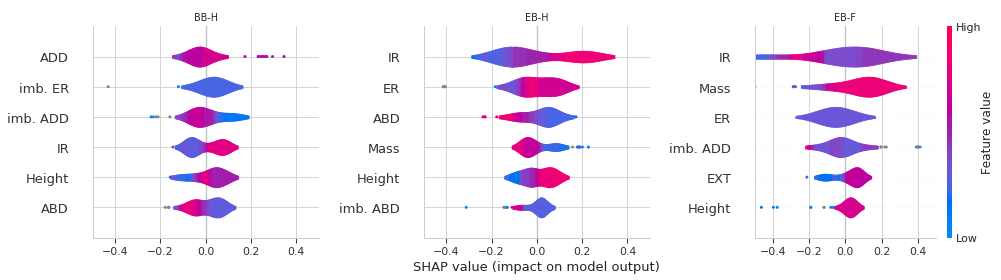

In [31]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
MAX_DISPLAY = 6

for i, itarget in enumerate(y.columns):
    color_bar = True if i == 2 else False

    plt.sca(ax[i])
    shap.summary_plot(
        shap_values[itarget],
        X_augmented,
        show=False,
        color_bar=color_bar,
        auto_size_plot=False,
        max_display=MAX_DISPLAY,
        plot_type="violin",
    )
    ax[i].set_title(itarget)
    ax[i].set_xlim(-0.5, 0.5)
    if i != 1:
        ax[i].set_xlabel("")
plt.grid(b=None, axis="y")
plt.tight_layout()
sns.despine()
plt.savefig("./share/fig/shap.svg", dpi=300)

### What is the prediction path?
The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output.

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [32]:
random_observation = np.random.randint(0, X_augmented.shape[0])

itarget = y.columns[0]

shap.force_plot(
    explainer[itarget].expected_value,
    shap_values[itarget][random_observation, :],
    X_augmented.iloc[random_observation, :],
)

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset

In [33]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

In [34]:
shap.force_plot(
    explainer[itarget].expected_value,
    shap_values[itarget][random_observation, :],
    X_augmented.iloc[random_observation, :],
)

In [35]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

In [36]:
itarget = y.columns[2]

shap.force_plot(
    explainer[itarget].expected_value,
    shap_values[itarget][random_observation, :],
    X_augmented.iloc[random_observation, :],
)

In [37]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

### How is target variable related with important features?
The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all observations we can see how changes in the feature's value effect the model's output.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset.

Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in fatigue as AveShEleMean changes.

Vertical dispersion at a single value of AveShEleMean represents interaction effects with other features.

To help reveal these interactions dependence_plot automatically selects another feature for coloring.

In this case coloring by ROMTrYMean highlights that AveShEleMean has less impact on fatigue when ROMTrXMean decreases and conversely.

In [38]:
shap_df.head()

,ADD,imb. ADD,ABD,imb. ABD,ER,imb. ER,IR,imb. IR,EXT,imb. EXT,FLEX,imb. FLEX,Height,Mass,target
0,0.078267,-0.082596,0.054573,-0.006371,0.023017,0.053649,-0.073798,0.077072,-0.034692,-0.004663,0.020821,0.007862,-0.025242,-0.004405,BB-H
1,-0.043777,-0.052526,0.048637,-0.007598,0.020508,0.037481,-0.066901,-0.017164,0.002552,-0.002775,-0.047064,-0.071615,0.071267,-0.038406,BB-H
2,-0.036702,0.060207,0.024471,-0.215941,-0.027239,-0.049690,0.058906,-0.010001,-0.006167,-0.006003,0.075677,-0.042641,0.003425,-0.025219,BB-H
3,-0.022062,-0.021097,-0.084986,-0.037414,-0.025785,0.039169,-0.030420,-0.007726,0.060794,0.002699,-0.067460,0.021483,-0.069968,0.005106,BB-H
4,0.026675,-0.039703,0.016036,-0.006587,0.020775,0.066165,-0.114308,-0.020018,-0.031005,-0.003592,0.041372,0.046617,0.044594,-0.042595,BB-H


In [39]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[itarget]), axis=0))[:3]

In [40]:
shap_df.query("target == @itarget").drop("target", axis=1).abs().sum().sort_values(
    ascending=False
)

IR           17.105545
Mass         15.464747
ER            9.326838
imb. ADD      8.028214
EXT           6.424017
Height        4.462678
imb. ER       3.570564
ADD           3.439758
imb. ABD      3.117179
imb. EXT      3.097899
imb. IR       1.415316
FLEX          0.967243
ABD           0.786832
imb. FLEX     0.622232
dtype: float32

In [44]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[itarget]), axis=0))[:3]
top_inds

array([ 6, 13,  4])

In [65]:
shap_df.shape

(276, 15)

In [64]:
X_augmented.shape

(92, 14)

In [56]:
var = "imb. ER"
tx = X_augmented[var]
ty = shap_df.query("target == 'BB-H'")[var]

In [72]:
np.arange(90).shape

(90,)

,participant,variable,value
0,0,ADD,29.156099
1,1,ADD,30.343123
2,2,ADD,26.038531
3,3,ADD,22.446920
4,4,ADD,29.438773
5,5,ADD,32.951070
6,6,ADD,18.563165
7,7,ADD,27.698104
8,8,ADD,27.147428
9,9,ADD,32.971303


In [90]:
X_augmented.assign(participant=np.arange(X_augmented.shape[0])).melt(
    id_vars="participant"
).head()

,participant,variable,value
0,0,ADD,29.156099
1,1,ADD,30.343123
2,2,ADD,26.038531
3,3,ADD,22.446920
4,4,ADD,29.438773


In [93]:
shap_scatter_df = (
    shap_df.assign(participant=np.tile(np.arange(X_augmented.shape[0]), 3))
    .melt(id_vars=["target", "participant"], value_name="shap")
    .merge(
        X_augmented.assign(participant=np.arange(X_augmented.shape[0])).melt(
            id_vars="participant"
        ),
        on=["participant", "variable"],
    )
)

shap_scatter_df.head()

,target,participant,variable,shap,value
0,BB-H,0,ADD,0.078267,29.156099
1,EB-H,0,ADD,0.023185,29.156099
2,EB-F,0,ADD,0.037738,29.156099
3,BB-H,1,ADD,-0.043777,30.343123
4,EB-H,1,ADD,0.003566,30.343123


In [ ]:
alt.

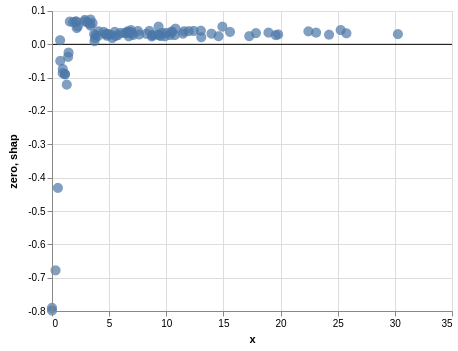

In [57]:
alt.Chart(pd.DataFrame({"zero": [0]})).mark_rule().encode(alt.Y("zero")) + alt.Chart(
    pd.DataFrame({"x": tx, "shap": ty})
).mark_circle(size=100).encode(
    alt.X("x", scale=alt.Scale(zero=False)), alt.Y("shap", scale=alt.Scale(zero=False))
)

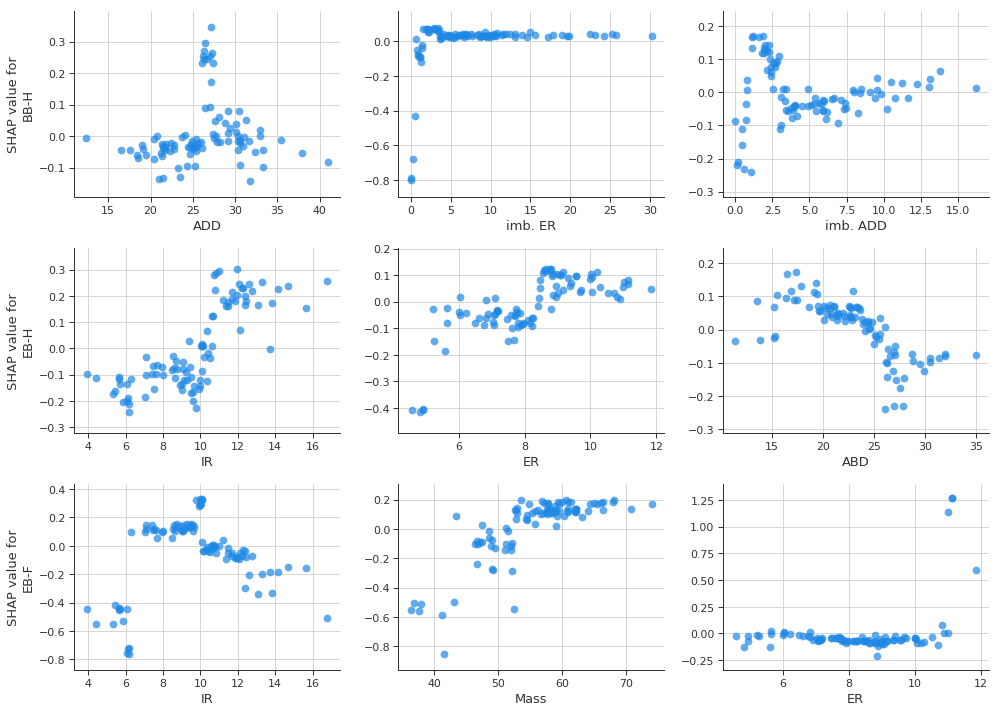

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))

for irow, itarget in enumerate(y.columns):
    # sort the features indexes by their importance in the model
    # (sum of SHAP value magnitudes over the validation dataset)
    top_inds = np.argsort(-np.sum(np.abs(shap_values[itarget]), axis=0))

    # make SHAP plots of the three most important features and their best interaction
    for icol, idx in enumerate(top_inds[:3]):
        plt.sca(ax[irow, icol])

        shap.dependence_plot(
            idx,
            shap_values[itarget],
            X_augmented,
            dot_size=60,
            interaction_index=None,
            alpha=0.7,
            show=False,
        )
        ax[irow, icol].set_ylabel("")
    ax[irow, 0].set_ylabel(f"SHAP value for\n{itarget}")

plt.gcf().set_size_inches(14, 10)
plt.tight_layout()
sns.despine()

### Supervised clustering
Clustering people by their shap values leads to groups relevent to the prediction task at hand.

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

itarget = y.columns[0]

shap_pca2 = PCA(n_components=2).fit_transform(shap_values[itarget][:, :-1])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(
    shap_values[itarget][:, :-1]
)

In [38]:
def plot_clusters(x, y, c, label, a):
    a.scatter(x, y, c=c, linewidth=0, alpha=0.8, s=60)
    PCM = a.get_children()[0]
    cb = plt.colorbar(PCM, label=label, aspect=40, orientation="horizontal", ax=a)
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params("x", length=0)
    cb.ax.xaxis.set_label_position("top")
    a.axis("off")

NameError: name 'feature_importance' is not defined

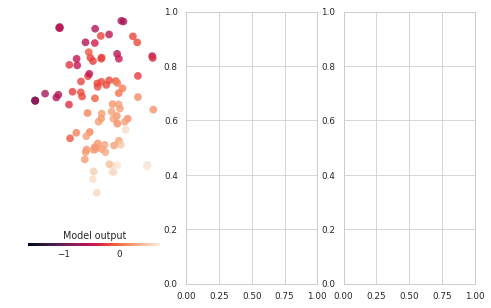

In [39]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=np.sum(shap_values[itarget], axis=1),
    a=ax[0],
    label="Model output",
)

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=X_augmented[feature_importance[itarget][0]],
    a=ax[1],
    label=feature_importance[itarget][0],
)

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=X_augmented[feature_importance[itarget][1]],
    a=ax[2],
    label=feature_importance[itarget][1],
)

plt.show()

## Optimization

In [27]:
from platypus import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

VAR = "BB-H"
candidate_idx = 0

candidate_height = X_augmented.iloc[candidate_idx, 12]
Initial_obs = X_augmented.iloc[[candidate_idx]].drop(columns=["Height"])
BB_H_initial = boosted[VAR].predict(X_augmented.iloc[[candidate_idx]])

desired = BB_H_initial + 0.5

shap_weight = np.delete(np.mean(np.abs(shap_values[VAR]), axis=0), 12)
shap_ponderation = 1 - shap_weight / np.sum(shap_weight)

n_var = X_augmented.shape[1] - 1
n_obj = 3


class Opt(Problem):
    def __init__(self):
        super(Opt, self).__init__(n_var, n_obj)
        self.types[0:11:2] = Real(0.8, 1.2)
        self.types[1:12:2] = Real(0.4, 1)
        self.types[12] = Real(0.8, 1.2)

    def evaluate(self, solution):
        x = solution.variables[:]
        real_x = x * Initial_obs
        Obs_variation = real_x.sub(Initial_obs, fill_value=0).abs()
        real_x.insert(12, "Height", candidate_height)
        Weighted_Obs_variation = Obs_variation * shap_ponderation
        Force_Obs_variation = Obs_variation
        Force_Obs_variation = (Force_Obs_variation / shap_ponderation).drop(
            columns=[
                "imb_ADD",
                "imb_ABD",
                "imb_ER",
                "imb_IR",
                "imb_EXT",
                "imb_FLEX",
                "Weight",
            ]
        )
        Imb_Obs_variation = (Obs_variation * shap_ponderation).drop(
            columns=["ADD", "ABD", "ER", "IR", "EXT", "FLEX"]
        )
        New_var = boosted[VAR].predict(real_x)
        #         solution.objectives[:] = np.append(np.abs(New_var-desired), np.sum(Weighted_Obs_variation.values))
        solution.objectives[:] = np.append(
            np.abs(New_var - desired),
            [np.sum(Force_Obs_variation.values), np.sum(Imb_Obs_variation.values)],
        )


algorithm = SMPSO(Opt())
algorithm.run(10000)

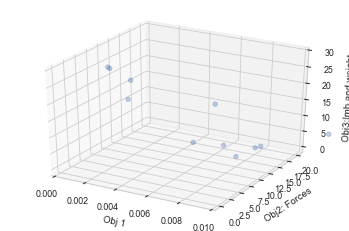

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# plt.scatter([s.objectives[0] for s in algorithm.result],[s.objectives[1] for s in algorithm.result])

ax.scatter(
    [s.objectives[0] for s in algorithm.result],
    [s.objectives[1] for s in algorithm.result],
    [s.objectives[2] for s in algorithm.result],
)
ax.set_xlabel("Obj 1")
ax.set_ylabel("Obj2: Forces")
ax.set_zlabel("Obj3:Imb and weight")
ax.set_xlim([0, 0.01])
# plt.axis([0,0.1, 0, 15])
plt.show()

In [29]:
def Left_Force(a, b):
    return a * (200 - b) / (200 - 2 * b)


def Right_Force(b, L):
    return L * (100 - b) / 100

In [32]:
Relative = True
output_path = f"./Evolutionary/_{candidate_idx}_{VAR}.txt"

output = pd.DataFrame(
    columns=[
        "ADD/G",
        "ADD/D",
        "ABD/G",
        "ABD/D",
        "ER/G",
        "ER/D",
        "IR/G",
        "IR/D",
        "EXT/G",
        "EXT/D",
        "FLEX/G",
        "FLEX/D",
        "Weight",
        "Obj_principal",
        "Obj_Forces",
        "Obj_Imb",
    ]
)
if Relative:
    for solution in unique(nondominated(algorithm.result)):
        Row = list()
        Left = list()
        Right = list()
        for n in range(6):
            Left = Left_Force(solution.variables[2 * n], solution.variables[2 * n + 1])
            Right = Right_Force(solution.variables[2 * n + 1], Left)
            Row += [Left]
            Row += [Right]
        Row.extend(
            [
                solution.variables[12],
                solution.objectives[0],
                solution.objectives[1],
                solution.objectives[2],
            ]
        )
        output.loc[len(output)] = Row
else:
    for solution in unique(nondominated(algorithm.result)):
        Row = list()
        Left = list()
        Right = list()
        for n in range(6):
            Left = Left_Force(
                solution.variables[2 * n] * X_augmented.iloc[candidate_idx][2 * n],
                solution.variables[2 * n + 1]
                * X_augmented.iloc[candidate_idx][2 * n + 1],
            )
            Right = Right_Force(
                solution.variables[2 * n + 1]
                * X_augmented.iloc[candidate_idx][2 * n + 1],
                Left,
            )
            Row += [Left]
            Row += [Right]
        Row.extend(
            [
                solution.variables[12] * X_augmented.iloc[candidate_idx][13],
                solution.objectives[0],
                solution.objectives[1],
                solution.objectives[2],
            ]
        )
        output.loc[len(output)] = Row
    print(X.iloc[[0]])

output.to_csv(output_path, sep="\t")
output.sort_values(by=["Obj_principal", "Obj_Imb"])

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D,Weight,Obj_principal,Obj_Forces,Obj_Imb
61,0.939700,0.930815,1.187458,1.180026,1.163401,1.151767,0.884791,0.877453,0.834247,0.829023,0.995880,0.986966,1.195402,0.000016,11.826405,22.266991
3,0.935632,0.927132,1.156727,1.149473,1.188387,1.177286,0.889094,0.883267,0.931740,0.925512,0.900927,0.894462,1.149325,0.000016,11.377593,23.017697
84,0.936311,0.927519,0.914097,0.906154,1.187533,1.177419,0.969978,0.961692,0.876749,0.871112,1.024675,1.015272,1.139154,0.001950,9.095934,16.297764
99,0.913858,0.905059,1.056436,1.050530,1.187816,1.179501,0.979097,0.973095,0.901210,0.895347,0.999014,0.991560,1.127584,0.002378,8.254917,23.060459
14,0.917290,0.908612,1.110096,1.099169,1.188579,1.180682,1.030463,1.025651,0.937871,0.928585,1.105092,1.094489,1.072277,0.005806,10.336506,5.516895
52,0.901392,0.893181,1.041582,1.035320,1.183024,1.173161,1.020600,1.015269,1.074145,1.066986,0.981025,0.973001,1.129133,0.007760,7.970357,20.807528
66,0.930470,0.922073,1.039013,1.030134,1.197814,1.188038,0.930073,0.923547,0.912267,0.903162,1.096021,1.085091,1.113599,0.008051,9.081731,7.707246
5,0.911208,0.902096,1.206061,1.194000,1.195804,1.187251,1.016345,1.010744,0.929433,0.920139,1.206061,1.194000,1.071893,0.009064,14.578027,4.177347
74,0.924353,0.915110,1.177418,1.165643,1.204610,1.195426,0.940112,0.933395,0.921535,0.912721,1.152974,1.141444,1.074243,0.009064,13.093269,4.855664
86,0.929219,0.920410,1.087855,1.077587,1.186093,1.178148,1.040245,1.032963,1.005051,0.995000,1.102094,1.091457,1.080277,0.009064,8.146788,5.930289


NSGAII
    Opt
        Hypervolume : [0.43219]
CMAES
    Opt
        Hypervolume : [0.33217]
GDE3
    Opt
        Hypervolume : [0.55172]
MOEAD
    Opt
        Hypervolume : [0.372]
OMOPSO
    Opt
        Hypervolume : [0.20814]
SMPSO
    Opt
        Hypervolume : [0.24576]
SPEA2
    Opt
        Hypervolume : [0.55386]
EpsMOEA
    Opt
        Hypervolume : [0.48925]


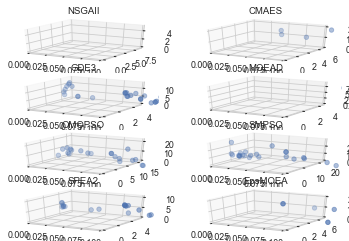

In [139]:
from platypus import *

if __name__ == "__main__":
    pbl = Opt()
    algo = [
        NSGAII,
        (CMAES, {"epsilons": [0.05]}),
        GDE3,
        MOEAD,
        (OMOPSO, {"epsilons": [0.05]}),
        SMPSO,
        SPEA2,
        (EpsMOEA, {"epsilons": [0.05]}),
    ]

    with ProcessPoolEvaluator() as evaluator:
        results = experiment(algo, pbl, seeds=1, nfe=10000)

    hyp = Hypervolume(minimum=[0, 0, 0], maximum=[0.5, 5, 12])
    hyp_result = calculate(results, hyp)
    display(hyp_result, ndigits=5)

    fig = plt.figure()

    for i, algo in enumerate(six.iterkeys(results)):
        result = results[algo]["Opt"][0]

        ax = fig.add_subplot(4, 2, i + 1, projection="3d")
        ax.scatter(
            [s.objectives[0] for s in result],
            [s.objectives[1] for s in result],
            [s.objectives[2] for s in result],
        )
        ax.set_title(algo)
        ax.set_xlim([0, 0.1])
        ax.locator_params(nbins=2)

    plt.show()

In [33]:
X.iloc[:2, :]
np.mean(np.abs(shap_values[VAR]), axis=0)
ROW = X_augmented.iloc[[29]]
ROW

,ADD,imb_ADD,ABD,imb_ABD,ER,imb_ER,IR,imb_IR,EXT,imb_EXT,FLEX,imb_FLEX,Height,Weight
29,24.07078,9.541731,16.380964,12.380122,6.000628,15.57377,5.693152,0.357462,8.527479,17.94181,14.897736,15.254237,1.46,37.64
